In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import keras
from random import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense,Bidirectional
from keras.layers import LSTM, Flatten, Input
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D,Dropout
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/mariekorneliusson/anaconda3/envs/dml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
path = os.path.normpath('/Users/mariekorneliusson/documents/AiSports/Strike_Data_As_Np')

In [3]:
X_First = np.load(path + '/' + 'X_First_Skier.npy')
Y_First = np.load(path + '/' + 'Y_First_Skier.npy')
feature_list_First = []
with open(path + "/keys_First_Skier.txt", "r") as f:
      for line in f:
        feature_list_First.append(line.strip('\n'))

In [4]:
X_Second = np.load(path + '/' + 'X_Second_Skier.npy')
Y_Second = np.load(path + '/' + 'Y_Second_Skier.npy')
feature_list_Second = []
with open(path + "/keys_Second_Skier.txt", "r") as f:
      for line in f:
        feature_list_Second.append(line.strip('\n'))

In [5]:
X_Third = np.load(path + '/' + 'X_Third_Skier.npy')
Y_Third = np.load(path + '/' + 'Y_Third_Skier.npy')
feature_list_Third = []
with open(path + "/keys_Third_Skier.txt", "r") as f:
      for line in f:
        feature_list_Third.append(line.strip('\n'))

In [6]:
feature_Dict = {i:feature_list_Second[i] for i in range(len(feature_list_Second)-1)}
print(len(feature_Dict))

17


In [7]:
print(X_First.shape)
print(X_Second.shape)
print(X_Third.shape)
print(Y_First.shape)
print(Y_Second.shape)
print(Y_Third.shape)

(452, 140, 22)
(382, 140, 18)
(844, 140, 22)
(452, 4)
(382, 4)
(844, 4)


In [19]:
def split_to_test_train_data(X_List,Y_List,ratio,time_step,dimX,nbr_of_classes):
    
    nbr_of_data_sets = len(X_List)
    min_samples = min([x.shape[0] for x in X_List])
    h = int((1-ratio)*min_samples)
    nbr_of_test = [x.shape[0]-h for x in X_List]
    X = np.zeros((h*nbr_of_data_sets,time_step,dimX))
    Y = np.zeros((h*nbr_of_data_sets,nbr_of_classes))
    X_Test_List = [np.zeros((sum(nbr_of_test),time_step,dimX))]
    Y_Test_List = [np.zeros((sum(nbr_of_test),nbr_of_classes))]
    
    for i in range(nbr_of_data_sets):
        x_d = np.zeros((nbr_of_test[i],time_step,dimX))
        y_d = np.zeros((nbr_of_test[i],nbr_of_classes))
        X_Test_List.append(x_d)
        Y_Test_List.append(y_d)

    test_samp_prev = 0 
    for i in range(nbr_of_data_sets):
        x = X_List[i][:,:,:dimX]
        y = Y_List[i]
        test_samp = nbr_of_test[i] + test_samp_prev
        X[h*i:h*(i+1),:,:] = x[:h,:,:]
        Y[h*i:h*(i+1),:] = y[:h,:]
        X_Test_List[0][test_samp_prev:test_samp,:,:] = x[h:,:,:]
        Y_Test_List[0][test_samp_prev:test_samp,:] = y[h:,:]
        X_Test_List[i+1] = x[h:,:,:]
        Y_Test_List[i+1] = y[h:,:]
        test_samp_prev = test_samp
        
    return X,Y,X_Test_List,Y_Test_List

In [26]:
dim_X = len(feature_Dict)
X_List = [X_First,X_Second,X_Third]
Y_List = [Y_First,Y_Second,Y_Third]
ratio = 0.2
time_step = 140
nbr_of_classes = 4
X,Y,X_Test_List,Y_Test_List = split_to_test_train_data(X_List,Y_List,ratio,time_step,dim_X,nbr_of_classes)
nbr_test = X_Test_List[0].shape[0]
X_Test = X_Test_List[0][:int((3*nbr_test)/4),:,:]
Y_Test = Y_Test_List[0][:int((3*nbr_test)/4),:]
X_Val = X_Test_List[0][int((3*nbr_test)/4):,:,:]
Y_Val = Y_Test_List[0][int((3*nbr_test)/4):,:]

In [27]:
print(X.shape)
print(Y.shape)
print(X_Test.shape)
print(Y_Test.shape)
print(X_Val.shape)
print(Y_Val.shape)

(915, 140, 17)
(915, 4)
(572, 140, 17)
(572, 4)
(191, 140, 17)
(191, 4)


In [28]:
def get_strike(strike,strike_l,pad):
    
    for j in range(strike_l-3):
        if strike[j,1] == strike[j+1,1] == strike[j+2,1] == pad:
            plot_strike = strike[0:j-1,1]
            time_strike = strike[0:j-1,0]
            break
        elif strike[strike_l-2,0] > 0:
            plot_strike = strike[:,1]
            time_strike = strike[:,0]
            break
    
    return plot_strike,time_strike

In [29]:
def change_time_axis_for_plot(X,delta_t):
    
    nbr_of_samples = X.shape[0]
    t = 0
    for i in range(nbr_of_samples):
        for j in range(140):
            X[i,j,0] = t*delta_t
            t = t + 1
    
    return X

In [30]:
def plot_skiedata(true_Y,X,figure):

    nbr_of_classes = 4
    colorDict = {0:'r',1:'fuchsia',2:'deeppink',3:'orange'}
    nameDict = {0:'Gear 2',1:'Gear 3',2:'Gear 4',3:'Double','Gear 2':0,'Gear 3':1,'Gear 4':2,'Double':3}
    nbr_of_test = X.shape[0]
    strike_l = X.shape[1]
    pad = 0

    for c in range(nbr_of_classes):
        true_c = np.where(true_Y == c)[0]
        strike_true = []
        strike_pred = []
        time_true = []
        time_pred = []
        for i in range(true_c.shape[0]):
            strike = X[true_c[i],:,:]
            t_strike,t_time = get_strike(strike,strike_l,pad)
            strike_true.extend(t_strike)
            time_true.extend(t_time)

        plt.figure(figure,figsize=(15, 4))
        plt.title('True gear')
        plt.scatter(time_true,strike_true,label = 'True class: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend()
        #plt.axis([280, 320, 0, 400])
    figure = figure + 1
    return figure

In [31]:
delta_t = 0.02
X = change_time_axis_for_plot(X,delta_t)
X_Test = change_time_axis_for_plot(X_Test,delta_t)
X_Val = change_time_axis_for_plot(X_Val,delta_t)

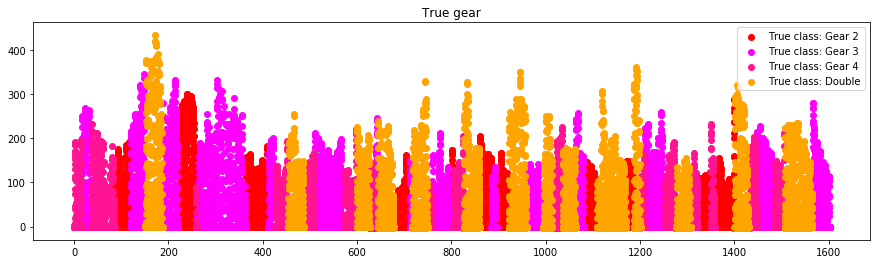

In [35]:
true_Y = np.argmax(Y_Test,axis = 1)
figure = plot_skiedata(true_Y,X_Test,0)

In [44]:
def CNN_One_Layer_26():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 26, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_One_Layer_38():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 38, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
def CNN_One_Layer_52():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 52, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_One_Layer_72():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 72, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_One_Layer_126():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 126, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model



Training model: CNN_One_Layer_26
Train on 915 samples, validate on 191 samples
Epoch 1/20
915/915 [==============================] - 4s 5ms/step - loss: 7.2544 - acc: 0.4404 - val_loss: 3.7647 - val_acc: 0.4293
Epoch 2/20
915/915 [==============================] - 4s 4ms/step - loss: 2.5774 - acc: 0.6492 - val_loss: 2.6592 - val_acc: 0.7277
Epoch 3/20
915/915 [==============================] - 4s 4ms/step - loss: 2.3677 - acc: 0.7246 - val_loss: 3.6360 - val_acc: 0.4660
Epoch 4/20
915/915 [==============================] - 4s 5ms/step - loss: 2.2684 - acc: 0.7497 - val_loss: 3.2003 - val_acc: 0.5393
Epoch 5/20
915/915 [==============================] - 4s 5ms/step - loss: 2.2357 - acc: 0.7650 - val_loss: 2.7622 - val_acc: 0.6806
Epoch 6/20
915/915 [==============================] - 4s 4ms/step - loss: 2.1789 - acc: 0.7902 - val_loss: 2.6374 - val_acc: 0.7382
Epoch 7/20
915/915 [==============================] - 4s 4ms/step - loss: 2.1803 - acc: 0.7934 - val_loss: 2.8347 - val_acc: 0.66

915/915 [==============================] - 3s 4ms/step - loss: 5.7076 - acc: 0.5803 - val_loss: 3.8529 - val_acc: 0.5236
Epoch 4/20
915/915 [==============================] - 3s 4ms/step - loss: 2.5537 - acc: 0.7268 - val_loss: 3.0446 - val_acc: 0.6021
Epoch 5/20
915/915 [==============================] - 3s 4ms/step - loss: 2.2239 - acc: 0.7891 - val_loss: 2.6771 - val_acc: 0.7435
Epoch 6/20
915/915 [==============================] - 3s 4ms/step - loss: 2.1568 - acc: 0.8011 - val_loss: 3.4182 - val_acc: 0.5916
Epoch 7/20
915/915 [==============================] - 3s 4ms/step - loss: 2.1539 - acc: 0.8087 - val_loss: 2.6206 - val_acc: 0.7749
Epoch 8/20
915/915 [==============================] - 4s 4ms/step - loss: 1.3091 - acc: 0.8426 - val_loss: 0.7784 - val_acc: 0.7958
Epoch 9/20
915/915 [==============================] - 4s 4ms/step - loss: 0.2665 - acc: 0.9169 - val_loss: 1.5512 - val_acc: 0.6597
Epoch 10/20
915/915 [==============================] - 4s 4ms/step - loss: 0.1724 - acc

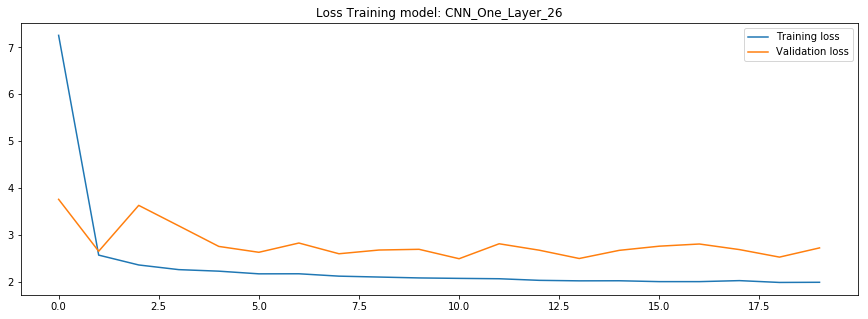

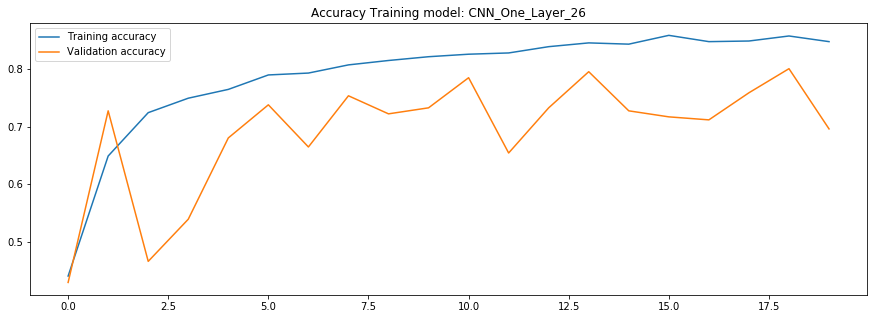

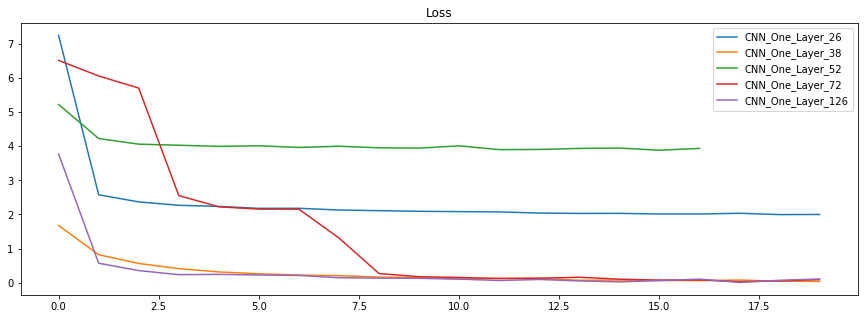

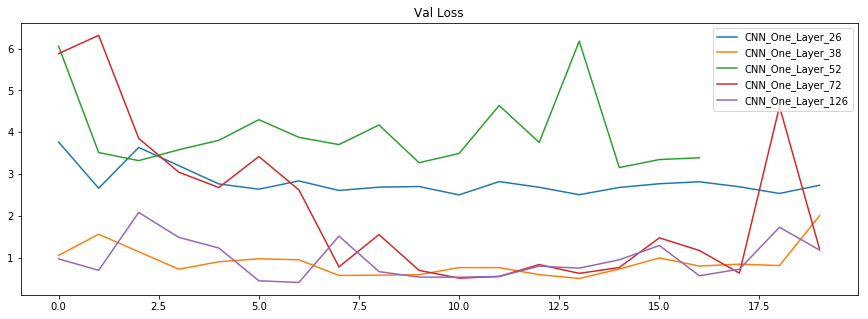

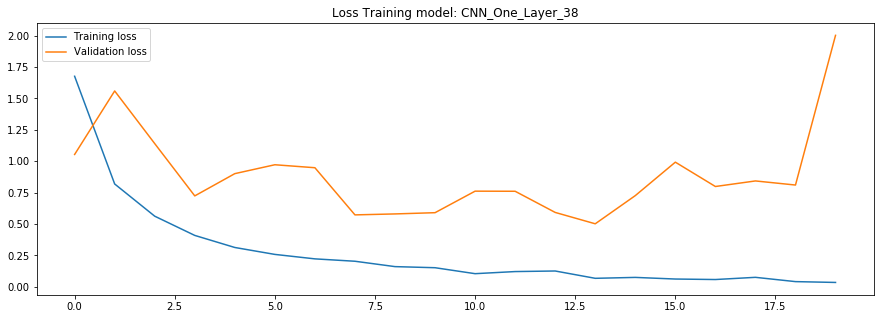

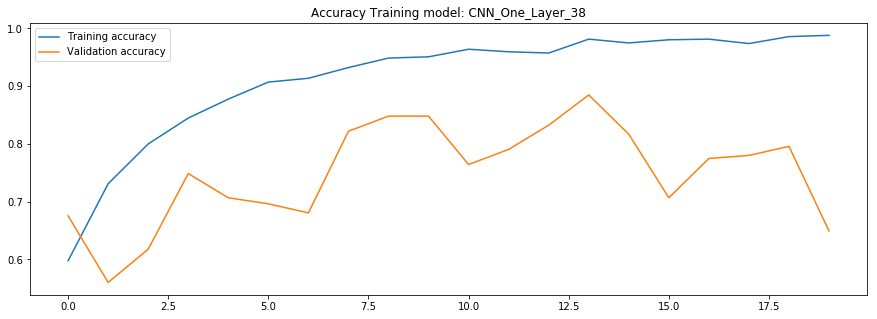

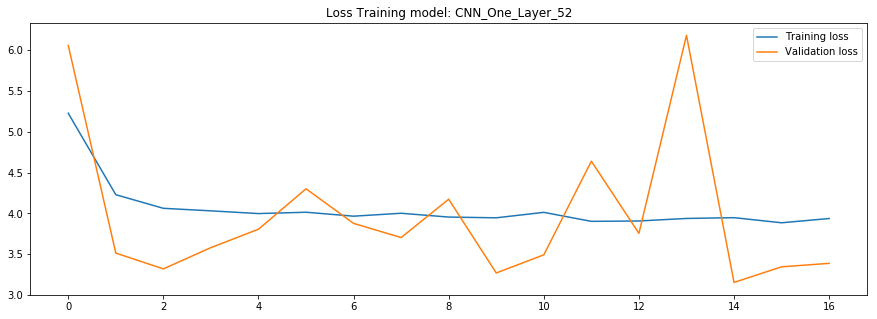

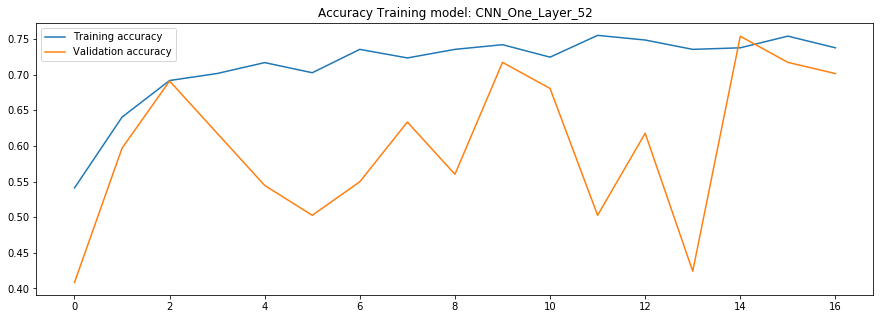

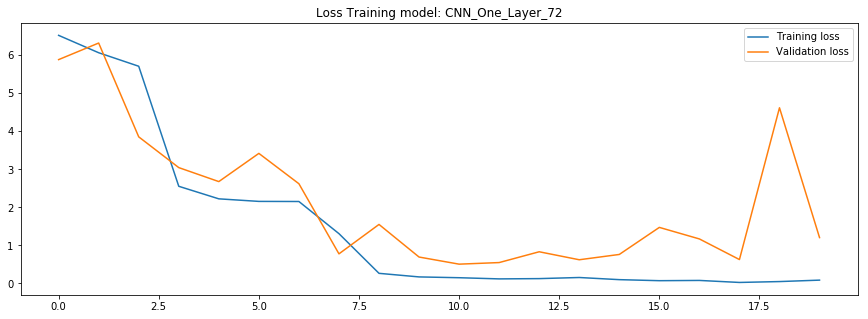

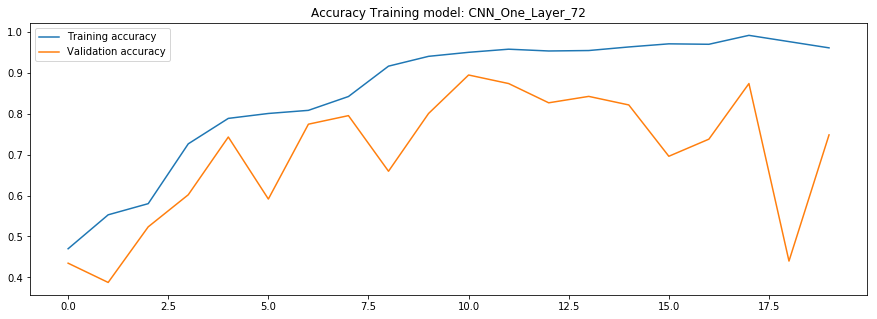

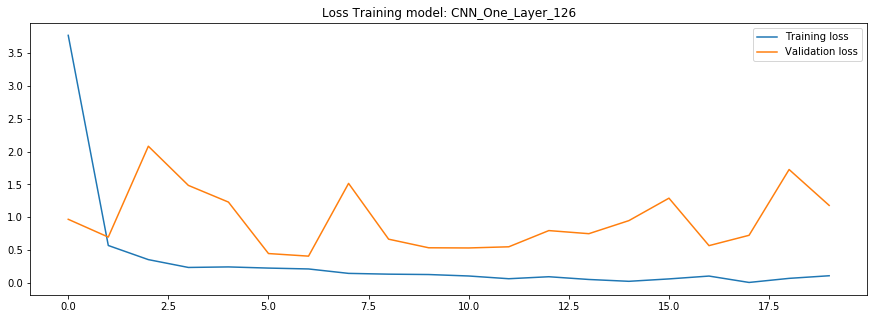

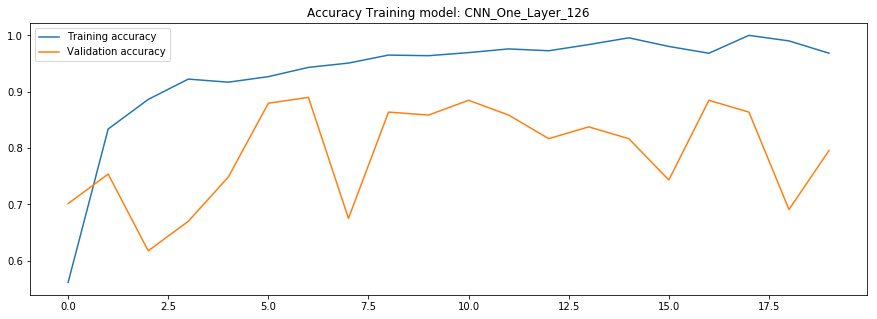

In [45]:
model_names = ['CNN_One_Layer_26','CNN_One_Layer_38','CNN_One_Layer_52','CNN_One_Layer_72','CNN_One_Layer_126']
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
i = 0
for name in model_names:
    print('Training model:',name)
    model = globals()[name]()
    #tb = TensorBoard(log_dir='./logs/'+name)
    history = model.fit(X[:,:,1:], Y, epochs=20, batch_size=1, validation_data=(X_Val[:,:,1:],Y_Val),shuffle = True,callbacks = [eS])
    print('Done!')
    plt.figure(2*i,[15,5])
    plt.title('Loss Training model: ' + name)
    plt.plot(history.history['loss'],label = 'Training loss')
    plt.plot(history.history['val_loss'],label = 'Validation loss')
    plt.legend()
    plt.figure(2*i + 1,[15,5])
    plt.plot(history.history['acc'],label = 'Training accuracy')
    plt.plot(history.history['val_acc'],label = 'Validation accuracy')
    plt.title('Accuracy Training model: ' + name)
    plt.legend()
    plt.figure(2*len(model_names),[15,5])
    plt.title('Loss')
    plt.plot(history.history['loss'],label = name)
    plt.legend()
    plt.figure(2*len(model_names) + 1,[15,5])
    plt.title('Val Loss')
    plt.plot(history.history['val_loss'],label = name)
    plt.legend()

    i = i + 1 

In [46]:
def CNN_Two_Layer_26():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 26, activation='relu', padding = "same")(sequence_input)
    x = MaxPooling1D(5)(x)
    x = Conv1D(kernel_size = (5), filters = 26, activation='relu', padding = "same")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_Two_Layer_52():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 52, activation='relu', padding = "same")(sequence_input)
    x = MaxPooling1D(5)(x)
    x = Conv1D(kernel_size = (5), filters = 52, activation='relu', padding = "same")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Training model: CNN_Two_Layer_26
Train on 915 samples, validate on 191 samples
Epoch 1/20
915/915 [==============================] - 6s 6ms/step - loss: 2.1393 - acc: 0.5781 - val_loss: 0.9186 - val_acc: 0.5812
Epoch 2/20
915/915 [==============================] - 4s 4ms/step - loss: 0.5722 - acc: 0.7934 - val_loss: 0.9087 - val_acc: 0.6230
Epoch 3/20
915/915 [==============================] - 4s 4ms/step - loss: 0.3909 - acc: 0.8601 - val_loss: 0.6146 - val_acc: 0.7382
Epoch 4/20
915/915 [==============================] - 4s 4ms/step - loss: 0.2760 - acc: 0.9115 - val_loss: 0.6657 - val_acc: 0.7277
Epoch 5/20
915/915 [==============================] - 4s 4ms/step - loss: 0.2114 - acc: 0.9311 - val_loss: 0.4974 - val_acc: 0.8115
Epoch 6/20
915/915 [==============================] - 4s 4ms/step - loss: 0.1773 - acc: 0.9486 - val_loss: 0.5782 - val_acc: 0.7696
Epoch 7/20
915/915 [==============================] - 4s 4ms/step - loss: 0.1558 - acc: 0.9443 - val_loss: 0.4935 - val_acc: 0.84

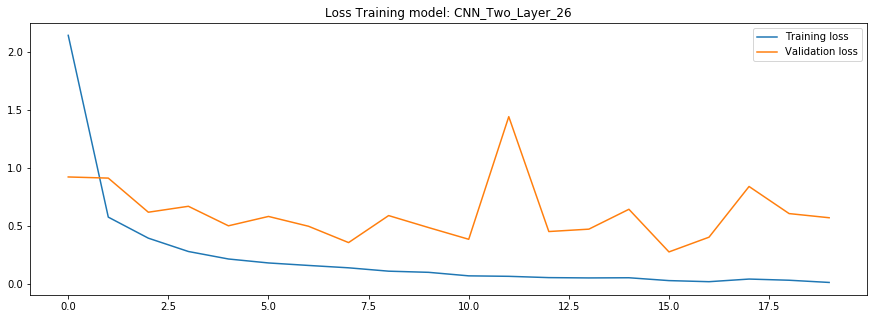

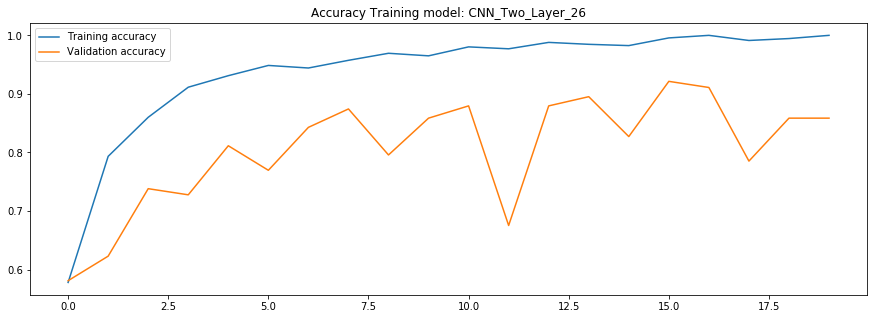

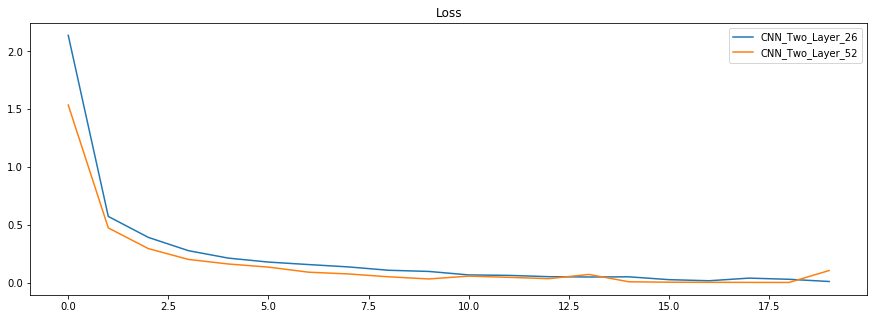

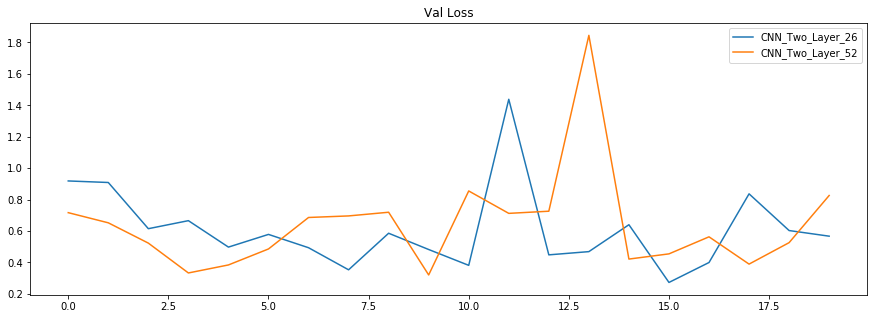

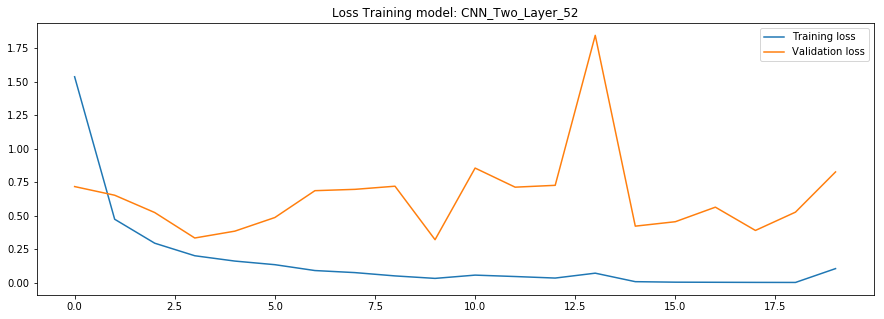

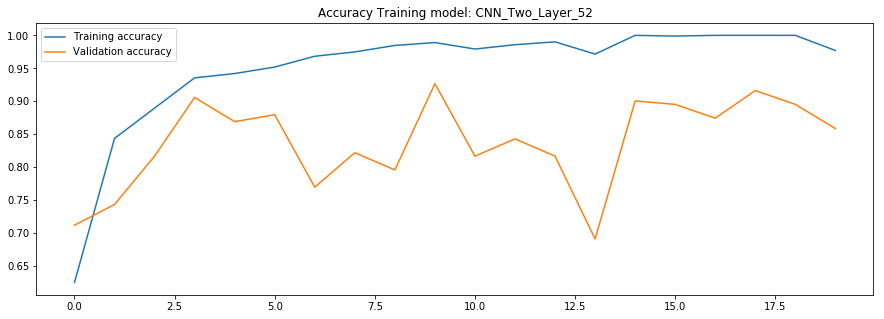

In [48]:
model_names = ['CNN_Two_Layer_26','CNN_Two_Layer_52']
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
i = 0
for name in model_names:
    print('Training model:',name)
    model = globals()[name]()
    #tb = TensorBoard(log_dir='./logs/'+name)
    history = model.fit(X[:,:,1:], Y, epochs=20, batch_size=1, validation_data=(X_Val[:,:,1:],Y_Val),shuffle = True,callbacks = [eS])
    print('Done!')
    plt.figure(2*i,[15,5])
    plt.title('Loss Training model: ' + name)
    plt.plot(history.history['loss'],label = 'Training loss')
    plt.plot(history.history['val_loss'],label = 'Validation loss')
    plt.legend()
    plt.figure(2*i + 1,[15,5])
    plt.plot(history.history['acc'],label = 'Training accuracy')
    plt.plot(history.history['val_acc'],label = 'Validation accuracy')
    plt.title('Accuracy Training model: ' + name)
    plt.legend()
    plt.figure(2*len(model_names),[15,5])
    plt.title('Loss')
    plt.plot(history.history['loss'],label = name)
    plt.legend()
    plt.figure(2*len(model_names) + 1,[15,5])
    plt.title('Val Loss')
    plt.plot(history.history['val_loss'],label = name)
    plt.legend()

    i = i + 1 

In [42]:
model = CNN_Two_Layer_52()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
mCp = ModelCheckpoint('CNN_1_2_3_New.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X[:,:,1:], Y, epochs=20, batch_size=1, validation_data=(X_Val[:,:,1:],Y_Val),shuffle = True,callbacks = [eS,mCp])

Train on 915 samples, validate on 191 samples
Epoch 1/20
915/915 [==============================] - 4s 5ms/step - loss: 1.2171 - acc: 0.6568 - val_loss: 1.7107 - val_acc: 0.5759
Epoch 2/20
915/915 [==============================] - 4s 4ms/step - loss: 0.4248 - acc: 0.8645 - val_loss: 0.9983 - val_acc: 0.6963
Epoch 3/20
915/915 [==============================] - 4s 4ms/step - loss: 0.2695 - acc: 0.9180 - val_loss: 0.8983 - val_acc: 0.7225
Epoch 4/20
915/915 [==============================] - 4s 4ms/step - loss: 0.2378 - acc: 0.9301 - val_loss: 0.7015 - val_acc: 0.7906
Epoch 5/20
915/915 [==============================] - 4s 4ms/step - loss: 0.1350 - acc: 0.9574 - val_loss: 1.0203 - val_acc: 0.7277
Epoch 6/20
915/915 [==============================] - 4s 4ms/step - loss: 0.1795 - acc: 0.9279 - val_loss: 0.3507 - val_acc: 0.9110
Epoch 7/20
915/915 [==============================] - 4s 4ms/step - loss: 0.1025 - acc: 0.9639 - val_loss: 2.3478 - val_acc: 0.6597
Epoch 8/20
915/915 [==========

In [43]:
from keras.models import load_model
model = load_model('CNN_1_2_3_New.h5')
predY = model.predict(X_Test[:,:,1:])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_Test,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

(572, 4)
Accuracy: 0.93
